In [12]:
!pip install gpytorch
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 KB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.6/155.6 KB 8.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.3/29.3 MB 30.2 MB/s eta 0:00:00


In [ ]:
To open on Google Colab\
https://colab.research.google.com/github/RodrigoAVargasHdz/CHEM-4PB3/blob/main/Course_Notes/Week5/TanimotoKernel.ipynb

# Kernel for strings

The kernel between two strings $\mathbf{x}$ and $\mathbf{x}'$ can be defined as,\
$k(x,x') = \sum_{a\in{\cal A}^*}\omega_s \phi_s(\mathbf{x})\phi_s(\mathbf{x}')$,\
where 
*  $\phi_s(\mathbf{x})$ denote the number of times that substring $s$ appears in string $\mathbf{x}$
* ${\cal A}$ is the alphabet of characters.
* $\omega_s$ is a non-negative weight for substring $s$
</br>
</br>

(**Example from Ref. [2](https://papers.nips.cc/paper/2000/file/68c694de94e6c110f42e587e8e48d852-Paper.pdf)**)\
![Arrays](https://raw.github.com/RodrigoAVargasHdz/CHEM-4PB3/master/Course_Notes/Figures/StringKernel.png)


</br>
</br>

**References**
1. [GP Book, Chapter 4, Section 4.4](https://gaussianprocess.org/gpml/chapters/) 
2. [(paper) Text classification with string kernels](https://papers.nips.cc/paper/2000/file/68c694de94e6c110f42e587e8e48d852-Paper.pdf)
3. [(paper) GAUCHE: A Library for Gaussian Processes in Chemistry](https://ml4physicalsciences.github.io/2022/files/NeurIPS_ML4PS_2022_75.pdf)
4. [(Wiki) String kernels](https://en.wikipedia.org/wiki/String_kernel)

# Kernels for molecules
**Reference**: [paper](https://papers.nips.cc/paper/2000/file/68c694de94e6c110f42e587e8e48d852-Paper.pdf)

## Scalar product kernel
$k_{\text{Scalar Product}}(\mathbf{x},\mathbf{x}') = \ell \cdot \langle \mathbf{x},\mathbf{x}' \rangle$, \
where
* $\langle \mathbf{x},\mathbf{x}' \rangle$ is the  Euclidean inner product; $\langle \mathbf{x},\mathbf{x}' \rangle = \sum_i x_i x'_i$.
* $\ell$ is a scalar signal variance hyperparameter.
</br>
</br>

## Tanimoto kernel
General similarity metric for **binary attributes**, used in [Ref.](https://doi.org/10.1016/j.neunet.2005.07.009) for cheminformatics.

$k_{\text{Tanimoto}}(\mathbf{x},\mathbf{x}') = \ell \cdot \frac{\langle \mathbf{x},\mathbf{x}' \rangle}{\|\mathbf{x} \|^2 + \|\mathbf{x}'\|^2 - \langle \mathbf{x},\mathbf{x}' \rangle}$, \
where
* $\| \;\; \|$ is the Euclidian norm
* $\mathbf{x}$ is a binary vector, $x_i = \{0,1\}$
</br>
</br>

## Graph kernel
$k_{\text{Gprah}}(g,g') = \ell \cdot \langle \phi(g),\phi(g') \rangle_{{\cal H}}$,
where,
* $\langle \phi(g),\phi(g') \rangle_{{\cal H}}$  measures the similarity betweene two molecular graphs. Related to graph isomorphism. 
* $\ell$ is a scalar signal variance hyperparameter.

The graph kernel was used in our previuos tutorial [link](https://colab.research.google.com/github/RodrigoAVargasHdz/CHEM-4PB3/blob/main/Course_Notes/Week5/gpytorch_molecules.ipynb)





# Code

In [13]:
import numpy as np
import pandas as pd
import torch
import gpytorch
from gpytorch.kernels import Kernel
from rdkit.Chem import AllChem, Descriptors, MolFromSmiles
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

## Tanimoto kernel in Torch
Code is based on this [online tutorial](https://towardsdatascience.com/gaussian-process-regression-on-molecules-in-gpflow-ee6fedab2130), where $k_{\text{Tanimoto}}(\cdot,⋅)$ was coded in TensorFlow. \
For defining your own kernel in Gpytorch, one can follow the following [tutorial](https://docs.gpytorch.ai/en/stable/examples/00_Basic_Usage/Implementing_a_custom_Kernel.html).



In [91]:
from gpytorch.constraints import Positive
from torch import Tensor

# from ChatGPT
# '''Write me a code compatible with GPyTorch for the Tanimoto kernel function'''
# '''remove the lengthscale parameter'''
class TanimotoKernel(gpytorch.kernels.Kernel):
    def __init__(self, active_dims=None):
        super(TanimotoKernel, self).__init__(active_dims=active_dims)
        self.register_parameter(
            name="raw_variance", parameter=torch.nn.Parameter(torch.zeros(1))
        )
        self.register_constraint("raw_variance", gpytorch.constraints.Positive())

    @property
    def variance(self):
        return self.raw_variance_constraint.transform(self.raw_variance)

    @variance.setter
    def variance(self, value):
        self.raw_variance = self.raw_variance_constraint.inverse_transform(value)

    def forward(self, x1, x2, **params):
        x1_ = x1.unsqueeze(-2)
        x2_ = x2.unsqueeze(-3)
        numerator = torch.sum(x1_ * x2_, dim=-1)
        denominator = torch.sum(x1_ + x2_ - x1_ * x2_, dim=-1)
        return self.variance * numerator / denominator

In [98]:
# a = torch.randn((3,5))
x1 = (torch.rand(size=(2,10)) < 0.35).int()
print('Random vectors')
print(x1)

kernel = TanimotoKernel()
K = kernel.forward(x1,x1) ## is this corrrect?
print('Kernel matrix')
print(K)

Random vectors
tensor([[1, 1, 0, 0, 0, 1, 0, 0, 0, 0],
        [1, 0, 0, 1, 0, 0, 0, 1, 0, 1]], dtype=torch.int32)
Kernel matrix
tensor([[0.6931, 0.1155],
        [0.1155, 0.6931]], grad_fn=<DivBackward0>)


# Example Caffeine

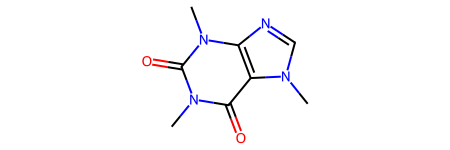

In [151]:
caff_sm = 'CN1C=NC2=C1C(=O)N(C(=O)N2C)C'
m = MolFromSmiles(caff_sm)
m

In [152]:
m_fingerprints = AllChem.GetMorganFingerprintAsBitVect(m, radius=3, nBits=2048)
x = np.asarray(m_fingerprints)
print(x.shape, len(np.where(x==0)[0]),len(np.where(x==1)[0]))

(2048,) 2014 34


Molecules similar to caffeine [link](https://www.acs.org/education/resources/highschool/chemmatters/past-issues/archive-2013-2014/caffeine.html)\
[Paraxanthine](https://en.wikipedia.org/wiki/Paraxanthine)

(2048,)


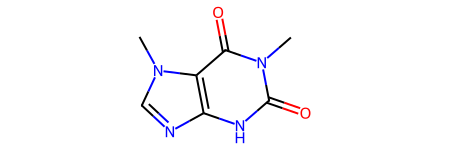

In [153]:
# Paraxanthine
para_sm = 'O=C2Nc1ncn(c1C(=O)N2C)C'
m1 = MolFromSmiles(para_sm)
m1_fingerprints = AllChem.GetMorganFingerprintAsBitVect(m1, radius=2, nBits=2048)
x1 = np.asarray(m1_fingerprints)
print(x1.shape)
m1

Evaluate the Tanimoto kernel.

In [154]:
x_caf = torch.from_numpy(x).unsqueeze(0)
print(x)
x_parax = torch.from_numpy(x1).unsqueeze(0)
print('Tanimoto kernel for, Caffein-Paraxanthine: ',kernel.forward(x_caf,x_parax))
print('Tanimoto kernel for, Caffein-Paraxanthine: ',kernel.forward(x_caf,x_caf))
print('Tanimoto kernel for, Paraxanthine-Paraxanthine: ',kernel.forward(x_parax,x_parax))

[0 0 0 ... 0 0 0]
Tanimoto kernel for, Caffein-Paraxanthine:  tensor([[0.2678]], grad_fn=<DivBackward0>)
Tanimoto kernel for, Caffein-Paraxanthine:  tensor([[0.6931]], grad_fn=<DivBackward0>)
Tanimoto kernel for, Paraxanthine-Paraxanthine:  tensor([[0.6931]], grad_fn=<DivBackward0>)


# More data!!

In [155]:
data_url = "https://github.com/RodrigoAVargasHdz/CHEM-4PB3/raw/main/Course_Notes/data/solubility.csv"
data = pd.read_csv(data_url)
print(data.columns)

Index(['ID', 'Name', 'InChI', 'InChIKey', 'SMILES', 'Solubility', 'SD',
       'Ocurrences', 'Group', 'MolWt', 'MolLogP', 'MolMR', 'HeavyAtomCount',
       'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRotatableBonds',
       'NumValenceElectrons', 'NumAromaticRings', 'NumSaturatedRings',
       'NumAliphaticRings', 'RingCount', 'TPSA', 'LabuteASA', 'BalabanJ',
       'BertzCT'],
      dtype='object')


In [157]:
# construct an histogram over the Tanimoto kernel with respect to Caffeine
def get_fingerprints(molecule_smile,torch_bool = False):
  m1 = MolFromSmiles(molecule_smile)
  m1_fingerprints = AllChem.GetMorganFingerprintAsBitVect(m1, radius=2, nBits=2048)
  x1 = np.asarray(m1_fingerprints)
  if torch_bool:
    return torch.from_numpy(x1)
  else:
    return x1

In [158]:

molecules = data['SMILES'][:10]
print(molecules)

0                  [Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C
1                                 O=C1Nc2cccc3cccc1c23
2                                      Clc1ccc(C=O)cc1
3    [Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...
4    C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...
5                                       Cc1cccc(C=C)c1
6                                  CCC1CCC(CCC(O)=O)C1
7    CC12CC(O)C3C(CCC4=CC(=O)C=CC34C)C1CC(O)C2(O)C(...
8                          Fc1ccc(cc1)C(=O)c2ccc(F)cc2
9                  O=C(OCCCOCCCOC(=O)c1ccccc1)c2ccccc2
Name: SMILES, dtype: object


In [159]:
X = []
for m in molecules:
  x = get_fingerprints(m,False)
  print(m)
  print(np.where(x != 0))
  X.append(x)


X = torch.from_numpy(np.asarray(X))
k_t = kernel.forward(x_caf,X)
print(k_t)
  

[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C
(array([  80,  294,  319,  414,  550,  591,  628,  780,  794,  913, 1057,
       1143, 1312, 1360, 1444, 1911]),)
O=C1Nc2cccc3cccc1c23
(array([ 314,  352,  527,  650,  725,  984, 1039, 1060, 1087, 1088, 1114,
       1380, 1470, 1498, 1646, 1657, 1750, 1833, 1855, 1873, 1893, 1982,
       1984]),)
Clc1ccc(C=O)cc1
(array([  25,  216,  561,  650,  694,  816,  932,  963, 1004, 1063, 1070,
       1380, 1683, 1750, 1873, 2033]),)
[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)C([O-])=O.CC(c4ccccc4)c5cc(C(C)c6ccccc6)c(O)c(c5)C([O-])=O
(array([   1,   82,  202,  237,  283,  358,  389,  650,  670,  715,  769,
        775,  786,  802,  807,  875, 1057, 1088, 1199, 1226, 1365, 1368,
       1380, 1388, 1405, 1406, 1568, 1581, 1602, 1750, 1873, 1917, 1955,
       1991]),)
C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO6)cc3
(array([  80,  310,  656,  658,  802,  834,  881,  886,  926,  960, 1019,
       1063, 1077, 1096, 1380, 1391, 1430, 1523, 1649, 1687, 1750, 17